<h1> What is Micrograd?</h1> <br> <p>Micrograd is  an automatic gradient function that allows for backpropogation. Backpropogation allows for the efficient evaluation of a loss function with respect to the weights of the network so we can tune the weights to minimize the loss to improve accuracy. All modern neural networks use backpropogation By the way, this is a scalar valued engine.</p>

Backpropogation goes backwards and recursively applies the Calculus Chain Rule and evaluated the derivative of the value with respect to its children and descendents. For example, let's say I have g and it has it's inputs/descendents as a-f. If I call g.backward(), I can then call a.grad to get dg/da. Also, I can call g.data before g.backward() in order to get the forward pass with micrograd. Micrograd is scalar valued autograd network. Micrograd is not useful in prod but helps us understand neural networks, but conventional networks have a lot of other stuff but mostly it is for efficiency.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

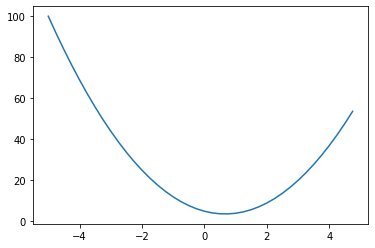

In [5]:
xs = np.arange(-5,5,0.25) # This just makes xs an array from -5 to 5 in steps of 0.25 without including the endpoint
ys = f(xs)
plt.plot(xs,ys) # Correctly parabolic

<h2>Just to start off, let's look at some simple calculus and how we would implement it in code</h2>

In [6]:
#How to take derivative in code
# Use the limit and difference quotient
h = 0.00000001
x = 2/3
(f(x+h)-f(x))/h

0.0

In [7]:
#let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
d

4.0

In [8]:
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c

# a - partial derivatives
a += h
d2 = a*b + c
print ('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [24]:
# Since Neural Networks deal with massive expressions/values, our data structure must be able to handle this
class Value:
    def __init__(self,data,_children = (),_op='',label=''): # Constructor, children is a tuple but prev will be set
        # op just allows us to know how the children were combined since the children property doesnt share that
        self.data = data
        # grad is gradient
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None # by default does nothing but will be function to propogate the gradient
    def __repr__(self): # This is a to String Method that makes it look nice even if I don't call the method
        return f"Value(data={self.data})"
    def __add__(self,other): # defines addition by + operator
        other = other if isinstance(other, Value) else Value(other) # Wrapper in case we do numerical arithmetic
        out = Value(self.data+other.data,(self,other),'+') # Typical floating point addition
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    def __mul__(self,other): # defines addition by * operator
        other = other if isinstance(other, Value) else Value(other) # Wrapper in case we do numerical arithmetic
        out = Value(self.data*other.data,(self,other),'*') # Typical floating point multiplication
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __rmul__(self,other): # This method is what Python calls if the original mul fails which can happen if we do other * self if other is a number
        return self * other
    def __radd__(self,other): # This method is what Python calls if the original add fails which can happen if we do other + self if other is a number
        return self + other
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def __truediv__(self,other): # self/other
        return self * other ** -1
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "Only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out
    def __sub__(self,other):
        return self + (-other)
    def __neg__(self):
        return self * -1
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        # Reverse Toposort Implementation (Specifically Tarjan's Algo)
        # Wrapper Method for backward method. 
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e=a*b; e.label='e'
d = e + c;d.label='d' #multiplication before addition by order of operations
f = Value(-2.0,label='f')
L = d*f; L.label='L'

In [10]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [11]:
d._op

'+'

In [49]:
from graphviz import Digraph
def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,label = "{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op,uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

In [50]:
# we will start of with a 2d neuron (2 inputs)
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0,label='x2')
# weights
w1 =Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


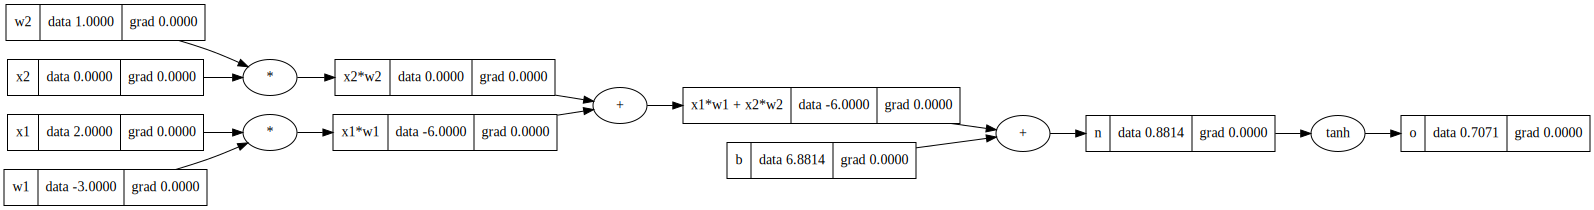

In [51]:
draw_dot(o)

In [52]:
# We care about derivatives of the weights because we're going to be playing with the derivatives to tune the data values

o.grad = 1.0
#o = tanh(n)
#d/dn(tanh(n)) = 1 - (tanh(n))^2 and remember tanh(n) = o, so n.grad = 1-o^2
n.grad = 0.5

b.grad = 0.5
x1w1x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

#do/dx1 = do/da * da/dx1
x1.grad = 0.5 * -3
w1.grad = 0.5 * 2
x2.grad = 0.5 * 1
w2.grad = 0.5 * 0

<h3>Now, let's look at how we can do an automatic backpropogation calculation. This will be implemented in the Value class</h3>

In [53]:
o.grad = 1.0


In [54]:
o._backward()

In [55]:
n._backward()

In [56]:
x1w1x2w2._backward()

In [57]:
x2w2._backward()
x1w1._backward()
x1._backward()

<h3>Now we want to remove the manual ._backward() calls. We can do this by toposort</h3>

In [58]:
o.backward()

<h3>Now a simple bug we forgot about</h3>

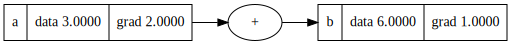

In [59]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)
# we are getting that db/da = 1.0 when it is 2.0 since our addition is the same. forgot to check if self = other

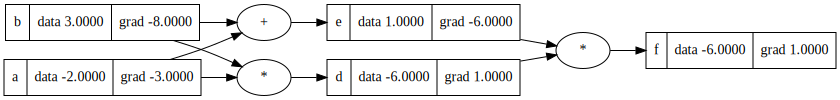

In [60]:
# Another example of bug
a = Value(-2.0, label='a')
b = Value(3.0,label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

<h3>The bug is that if a variable is used more than once, our code breaks. First time, we used the same variable multiple times and it didn't account for it in the same expression. Essentially, the problem is that we used the single variable chain rule and not the multivariate chain rule</h3>

In [61]:
#We'll come back to these variables now:
# we will start of with a 2d neuron (2 inputs)
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0,label='x2')
# weights
w1 =Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

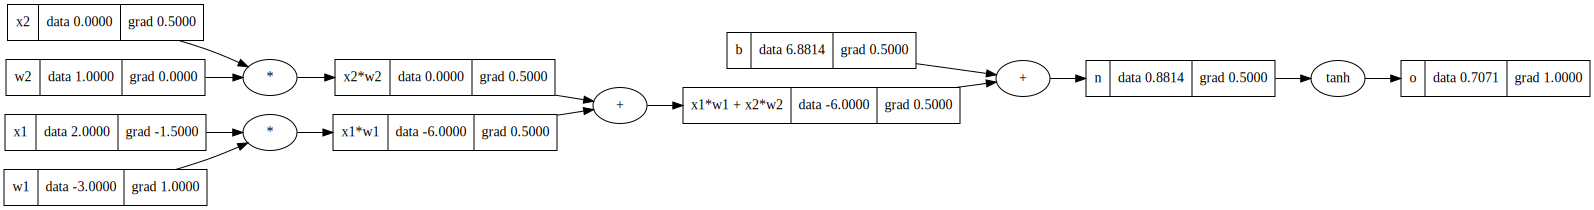

In [62]:
draw_dot(o)

<h3>Let's implement exponentiation now and operations with numbers!</h3>

<h3>Now, let's see the breakup of tanh</h3>

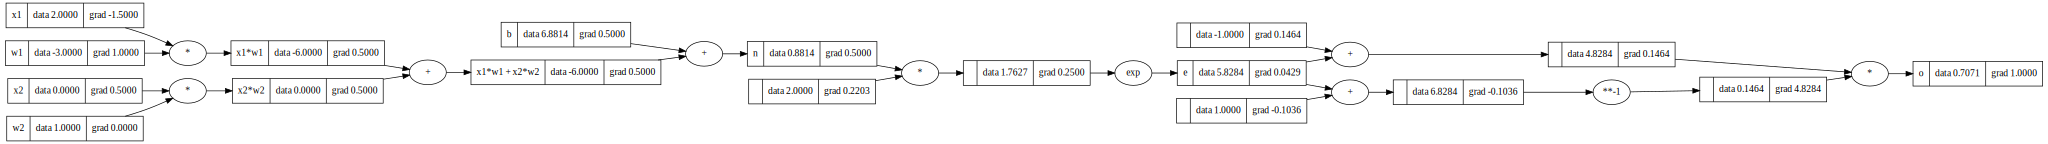

In [63]:
#We'll come back to these variables now:
# we will start of with a 2d neuron (2 inputs)
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0,label='x2')
# weights
w1 =Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
e.label = 'e'
o = (e - 1)/(e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

<h1>That ends the simple part of the micrograd engine and its examples! Now, let's look at a commercial backpropogation engine called PyTorch. PyTorch uses Tensors instead of Scalars</h1>

In [64]:
import torch
import random
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b # basically like we do in micrograd
o = torch.tanh(n)
 # we also have .data and .grad attributes. only thing is now we need to call .item because now we want to remove the tensor portions
 # basically the tensor object has 3 things: value, datatype of the value, and function for the gradient (basically _op from micrograd)
print(o.data.item())
o.backward()

print('---')
print('x2',x2.grad.item())
print('w2',w1.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

# it gives us the same gradients as before which suggests that our engine matches the PyTorch library

0.7071066904050358
---
x2 0.5000001283844369
w2 1.0000002567688737
x1 -1.5000003851533106
w1 1.0000002567688737


In [65]:
torch.Tensor([[1,2,3],[4,5,6]]) # a 2x3 tensor

tensor([[1., 2., 3.],
        [4., 5., 6.]])

<h1>Let's build a Neuron, a Layer, and a Multi-Layer Perceptron</h1>

In [72]:
# Now let's build a neural network
class Neuron:
    def __init__(self,nin): #nin is # of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x): # the method __call__ allows you to call an object like a method. Like let's say for example I have a neuron n and some input x, I can call n(x) and it will call this method
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) # zip basically makes tuples of every input with weight so it's in pairs of (w_i, x_i) for all i
        out = act.tanh() # applying activation function
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self,nin,nout): # nin is # inputs, nout is # neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
class MLP: #Multi-Layer Perceptron
    def __init__(self,nin,nouts): # nouts is a list of nouts that defines the sizes of the nouts
        sz = [nin] + nouts # basically [nin] is the input layer and nouts has the sizes of all other layers
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # need all pairwise things for edges between the neurons
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        params = []
        for layer in self.layers:
            ls = layer.parameters()
            params.extend(ls)
        return params
    


In [91]:
x = [2.0,3.0]
n = Neuron(2)
print(n(x))


n = Layer(2,3)
print(n(x))


x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.36788884822366374)
[Value(data=0.5031768394193687), Value(data=-0.9419196399693531), Value(data=0.9714916313970449)]


Value(data=-0.283575141253956)

In [92]:
len(n.parameters())

41

In [93]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets


[Value(data=-0.283575141253956),
 Value(data=0.029855351095312902),
 Value(data=0.10094496825370859),
 Value(data=-0.2443286158575183)]

In [117]:
ypred = [n(x) for x in xs]
loss = sum ((yout - ygt) ** 2 for ygt, yout in zip(ys,ypred))
loss

Value(data=0.30858291458085974)

In [132]:
loss.backward()

In [99]:
n.layers[0].neurons[0].w[0].grad

-1.7870388565465527

<h2>Now we will finally implement gradient descent</h2>

In [133]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [101]:
n.layers[0].neurons[0].w[0].data

0.33754908528804106

In [134]:
ypred = [n(x) for x in xs]
loss = sum ((yout - ygt) ** 2 for ygt, yout in zip(ys,ypred))
loss

Value(data=0.00588188112102341)

In [135]:
# basically gradient descient is just doing forward pass, backward pass and then update
ypred

[Value(data=0.9992233297124417),
 Value(data=-0.9395373194899338),
 Value(data=-0.9528382595031168),
 Value(data=0.9988543983545113)]

In [136]:
n.parameters()

[Value(data=0.5920547087253297),
 Value(data=0.2667139066651456),
 Value(data=-0.7988686987402628),
 Value(data=-0.081813774786963),
 Value(data=0.43983813015562523),
 Value(data=0.5868393955578912),
 Value(data=0.9195963400810534),
 Value(data=0.29438666867034635),
 Value(data=-0.006104099136399314),
 Value(data=0.7165910889265974),
 Value(data=-0.6878446388741271),
 Value(data=-0.7007085834989825),
 Value(data=0.6560291093471144),
 Value(data=-0.25357982504823323),
 Value(data=0.8632396024599094),
 Value(data=-0.6123327098438157),
 Value(data=0.05710647984782695),
 Value(data=-0.883795609053743),
 Value(data=0.872100522679359),
 Value(data=-0.7428828458471936),
 Value(data=0.7630277262279105),
 Value(data=0.4739044989080946),
 Value(data=0.8247103531042418),
 Value(data=-0.09892931118827926),
 Value(data=0.48702748763316406),
 Value(data=1.0453720488102154),
 Value(data=-0.8767373862483665),
 Value(data=0.3504244803101134),
 Value(data=0.09705133699579506),
 Value(data=0.837494504300